OK, thus far we have been talking about linear models. All these can be viewed as a single-layer neural net. The next step is to move on to multi-layer nets. Training these is a bit more involved, and implementing from scratch requires time and effort. Instead, we just use well-established libraries. I prefer PyTorch, which is based on an earlier library called Torch (designed for training neural nets via backprop).

In [ ]:
import numpy as np
import torch
import torchvision

Torch handles data types a bit differently. Everything in torch is a *tensor*.

In [ ]:
a = np.random.rand(2,3)
b = torch.from_numpy(a)

# Q4.1 Display the contents of a, b

print(a)
print(b)

[[0.19844846 0.98266844 0.10256115]
 [0.15029746 0.11279763 0.18244582]]
tensor([[0.1984, 0.9827, 0.1026],
        [0.1503, 0.1128, 0.1824]], dtype=torch.float64)


The idea in Torch is that tensors allow for easy forward (function evaluations) and backward (gradient) passes.

In [ ]:
A = torch.rand(2,2)
b = torch.rand(2,1)
x = torch.rand(2,1, requires_grad=True)

y = torch.matmul(A,x) + b

print(y)
z = y.sum()
print(z)
z.backward()
print(x.grad)
print(x)

tensor([[0.9120],
        [1.6148]], grad_fn=<AddBackward0>)
tensor(2.5267, grad_fn=<SumBackward0>)
tensor([[1.3354],
        [0.7750]])
tensor([[0.5261],
        [0.7308]], requires_grad=True)


Notice how the backward pass computed the gradients using autograd. OK, enough background. Time to train some networks. Let us load the *Fashion MNIST* dataset, which is a database of grayscale images of clothing items.

In [ ]:
trainingdata = torchvision.datasets.FashionMNIST('./FashionMNIST/',train=True,download=True,transform=torchvision.transforms.ToTensor())
testdata = torchvision.datasets.FashionMNIST('./FashionMNIST/',train=False,download=True,transform=torchvision.transforms.ToTensor())


Let us examine the size of the dataset.

In [ ]:
# Q4.2 How many training and testing data points are there in the dataset? 
# What is the number of features in each data point?

print(len(trainingdata))
print(len(testdata))
image, label = trainingdata[0]
image.numel()

60000
10000


784

Let us try to visualize some of the images. Since each data point is a tensor (not an array) we need to postprocess to use matplotlib.

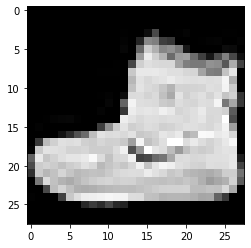

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

image, label = trainingdata[0]
# Q4.3 Assuming each sample is an image of size 28x28, show it in matplotlib.

plt.imshow(image.squeeze().numpy(),cmap=plt.cm.gray)
plt.show()


Let's try plotting several images. This is conveniently achieved in PyTorch using a *data loader*, which loads data in batches.

In [ ]:
trainDataLoader = torch.utils.data.DataLoader(trainingdata, batch_size=64, shuffle=True)
testDataLoader = torch.utils.data.DataLoader(testdata, batch_size=64, shuffle=False)
images, labels = iter(trainDataLoader).next()
print(images.size(), labels)

torch.Size([64, 1, 28, 28]) tensor([2, 6, 9, 0, 6, 3, 6, 3, 4, 4, 8, 2, 0, 4, 8, 1, 9, 5, 1, 1, 2, 4, 6, 7,
        1, 6, 6, 2, 5, 0, 7, 7, 6, 2, 5, 3, 9, 4, 9, 8, 5, 2, 5, 7, 1, 3, 7, 2,
        0, 7, 0, 1, 6, 2, 7, 6, 3, 3, 1, 4, 0, 9, 5, 7])


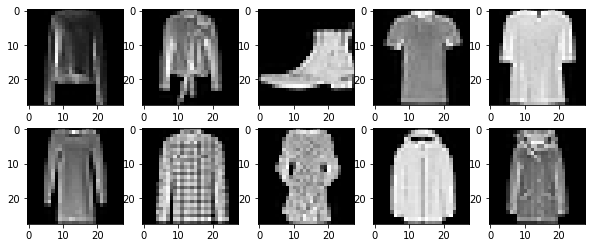

In [ ]:
# Q4.4 Visualize the first 10 images of the first minibatch 
# returned by testDataLoader.

plt.figure(figsize=(10,4))
for index in np.arange(0,10):
  plt.subplot(2,5,index+1)
  plt.imshow(images[index].squeeze().numpy(),cmap=plt.cm.gray)

Now we are ready to define our linear model. Here is some boilerplate PyTorch code that implements the forward model for a single layer network for logistic regression (similar to the one discussed in class notes). 

In [ ]:
class LinearReg(torch.nn.Module):
  def __init__(self):
    super(LinearReg, self).__init__()
    self.linear = torch.nn.Linear(28*28,10)

  def forward(self, x):
    x = x.view(-1,28*28)
    transformed_x = self.linear(x)
    return transformed_x

net = LinearReg().cuda()
Loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(), lr=0.01)



Cool! Now we have set everything up. Let's try to train the network.

In [ ]:
train_loss_history = []
test_loss_history = []

# Q4.5 Write down a for-loop that trains this network for 20 epochs, 
# and print the train/test losses.
# Save them in the variables above. If done correctly, you should be able to 
# execute the next code block.

for iters in range(20):
  train_loss = 0.0
  test_loss = 0.0
  for i, data in enumerate(trainDataLoader):
    images, labels = data
    images = images.cuda()
    labels = labels.cuda()
    optimizer.zero_grad()
    predicted_output = net(images)
    fit = Loss(predicted_output,labels)
    fit.backward()
    optimizer.step()
    train_loss += fit.item()
  for i, data in enumerate(testDataLoader):
    with torch.no_grad():
      images, labels = data
      images = images.cuda()
      labels = labels.cuda()
      predicted_output = net(images)
      fit = Loss(predicted_output,labels)
      test_loss += fit.item()
  train_loss = train_loss/len(trainDataLoader)
  test_loss = test_loss/len(testDataLoader)
  train_loss_history.append(train_loss)
  test_loss_history.append(test_loss)
  print('Iters %s, Train loss %s, Test loss %s'%(iters, train_loss, test_loss))


Iters 0, Train loss 0.9589588482623924, Test loss 0.7396021268929646
Iters 1, Train loss 0.6685111067061231, Test loss 0.6469626770277691
Iters 2, Train loss 0.6042172415678435, Test loss 0.6044433754720505
Iters 3, Train loss 0.5694338184302804, Test loss 0.5803748086379592
Iters 4, Train loss 0.5466556224042672, Test loss 0.5608065096056385
Iters 5, Train loss 0.5299777886125324, Test loss 0.5467861101126216
Iters 6, Train loss 0.5170556780880194, Test loss 0.5375607662899479
Iters 7, Train loss 0.5065596917989665, Test loss 0.529236364516483
Iters 8, Train loss 0.4986115480060262, Test loss 0.5219741364952865
Iters 9, Train loss 0.49126901623727415, Test loss 0.5155719735060528
Iters 10, Train loss 0.48490503983202776, Test loss 0.5112332832661404
Iters 11, Train loss 0.4796506513092818, Test loss 0.5062504949843049
Iters 12, Train loss 0.47493489221659807, Test loss 0.5014398447267568
Iters 13, Train loss 0.4707767970558169, Test loss 0.4982384183224599
Iters 14, Train loss 0.46668

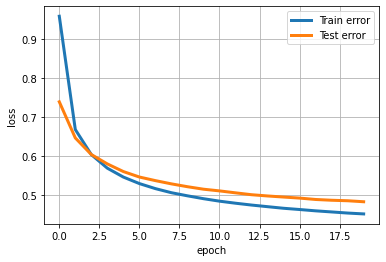

In [ ]:
plt.plot(range(20),train_loss_history,'-',linewidth=3,label='Train error')
plt.plot(range(20),test_loss_history,'-',linewidth=3,label='Test error')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.grid(True)
plt.legend()

Neat! Now let's evaluate our model accuracy on the entire dataset. The predicted class label for a given input image can computed by looking at the output of the neural network model and computing the index corresponding to the maximum activation. Something like

*predicted_output = net(images)*
*_, predicted_labels = torch.max(predicted_output,1)*

In [ ]:
predicted_output = net(images)
print(torch.max(predicted_output, 1))
fit = Loss(predicted_output, labels)
print(labels)

torch.return_types.max(
values=tensor([ 6.1657,  3.0111,  9.2405,  7.8143,  6.6697,  6.3233, 10.2428,  4.3455,
         6.8944, 11.7400, 10.5185, 10.4092,  6.7338,  4.5655,  9.4743,  4.5413],
       device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor([3, 1, 7, 5, 8, 2, 5, 6, 8, 9, 1, 9, 1, 8, 1, 5], device='cuda:0'))
tensor([3, 2, 7, 5, 8, 4, 5, 6, 8, 9, 1, 9, 1, 8, 1, 5], device='cuda:0')


In [ ]:
def evaluate(dataloader):
  # Q4.6 Implement a function here that evaluates training and testing accuracy.
  # Here, accuracy is measured by probability of successful classification.
  total, correct = 0, 0
  net.eval() # don't update weights
  for data in dataloader:
    images, labels = data
    images = images.cuda()
    labels = labels.cuda()
    predicted_output = net(images)
    _, predicted_labels = torch.max(predicted_output,1)
    total += labels.size(0)
    correct += (predicted_labels == labels).sum().item()
  return 100 * correct/total

print('Train acc = %0.2f, test acc = %0.2f' % (evaluate(trainDataLoader), evaluate(testDataLoader)))

Train acc = 84.84, test acc = 83.38
